In [3]:
""" Read the soil solution concentrations (umol/L) from 
Hubbard Brook watershed 1 """
import xarray as xr
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from shared_read_HBR import *
from matplotlib import cm
from utils import vert_interp

## Soil CEC content - initial state

The soil pedon file does not have Oi/Oe horizons. The CEC file only has Oi/Oe, Oa, and top 10cm mineral soils. 

Use the Oie & Oa values from the latter. The rest from the former. 

Average the soil profiles according to Oie, Oa, A, E, Bhs; deeper layers are not needed since only
keep track of top 30cm

In [4]:
# (1) Surface data
data = pd.read_excel(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                  'Hubbard_Brook', 'knb-lter-hbr.158.1',
                                  'w1ffexchem.xlsx'),
                     index_col = [3, 2])
data = data.loc[data['Year'] < 1999, :]

# 'Min', 'cor', 'min' probably all means mineral soil of top 10cm
new_index_level_0 = [t if t in ['Oa', 'Oie'] else 'Min' for t in data.index.get_level_values(0)]
data.index = pd.MultiIndex.from_arrays([new_index_level_0, data.index.get_level_values(1)], 
                                        names = ['Horizon','Plot'])
data = data[['pHs', 'ExAcidcmolc_kg','ExCacmolc_kg', 'ExMgcmolc_kg', 
             'ExNacmolc_kg', 'ExKcmolc_kg', 'ExAlcmolc_kg']].sort_index()
data[data < 0] = np.nan

# subtract the Al3+ from Acid exchange to get the H+
data['ExAcidcmolc_kg'] = data['ExAcidcmolc_kg'] - data['ExAlcmolc_kg'].values

# data = data.loc[['Oa','Oie'], :]
cec_top = data.groupby('Horizon').mean()
cec_top_05 = data.groupby('Horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 5, axis = 0), index = df.columns))
cec_top_95 = data.groupby('Horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 95, axis = 0), index = df.columns))

In [5]:
# (2) Deeper data, watershed 1; Can also use watershed 3 because it is a
#     hydrological reference watershed
path_pedon = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'Hubbard_Brook',
                            'knb-lter-hbr.210.2')
pedon = pd.read_csv(os.path.join(path_pedon, 'pedon.csv'))
pedon = pedon.loc[((pd.DatetimeIndex(pedon['date']).year <= 1998) & \
                   (pedon['project'] == 'WS1lys')) |
                  pedon['pedon'].str.startswith('WS3') |
                  pedon['pedon'].isin(['HB013', 'HB026', 'HB175']), 'pedon']

horizon = pd.read_csv(os.path.join(path_pedon, 'horizon.csv'))
horizon = horizon.loc[horizon['pedon'].isin(pedon), 
                      ['pedon', 'horizon', 'top_cm', 'base_cm', 'acid_KCl', 'pH_CaCl2', 
                       'Ca_NH4Cl', 'Mg_NH4Cl', 'K_NH4Cl', 'Na_NH4Cl', 'Al_NH4Cl']]
horizon.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_pedons.csv'))
#horizon['horizon'] = [
#    r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') else r \
#    for r in horizon['horizon']]
horizon['horizon'] = [r[:1] for r in horizon['horizon']]
bedrock_depth = horizon.loc[horizon['horizon'] == 'R', 'top_cm']

horizon_top = horizon.loc[horizon['horizon'].isin(['A', 'E', 'B', 'C']),
                            ['pedon', 'horizon', 'top_cm']].set_index(['horizon', 'pedon']).sort_index()
horizon_depth = horizon.loc[horizon['horizon'].isin(['A', 'E', 'B', 'C']),
                            ['pedon', 'horizon', 'base_cm']].set_index(['horizon', 'pedon']).sort_index()

horizon = horizon.loc[horizon['horizon'].isin(['A', 'E', 'B', 'C']), 
                      :].drop(['top_cm', 'base_cm'], axis = 1).set_index(['pedon', 'horizon'])
cec_min = horizon.groupby(['horizon']).mean()
cec_min_05 = horizon.groupby('horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 5, axis = 0), index = df.columns))
cec_min_95 = horizon.groupby('horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 95, axis = 0), index = df.columns))

Text(0.5, 1.0, 'Bedrock depth (Watershed 1 + Watershed 3)')

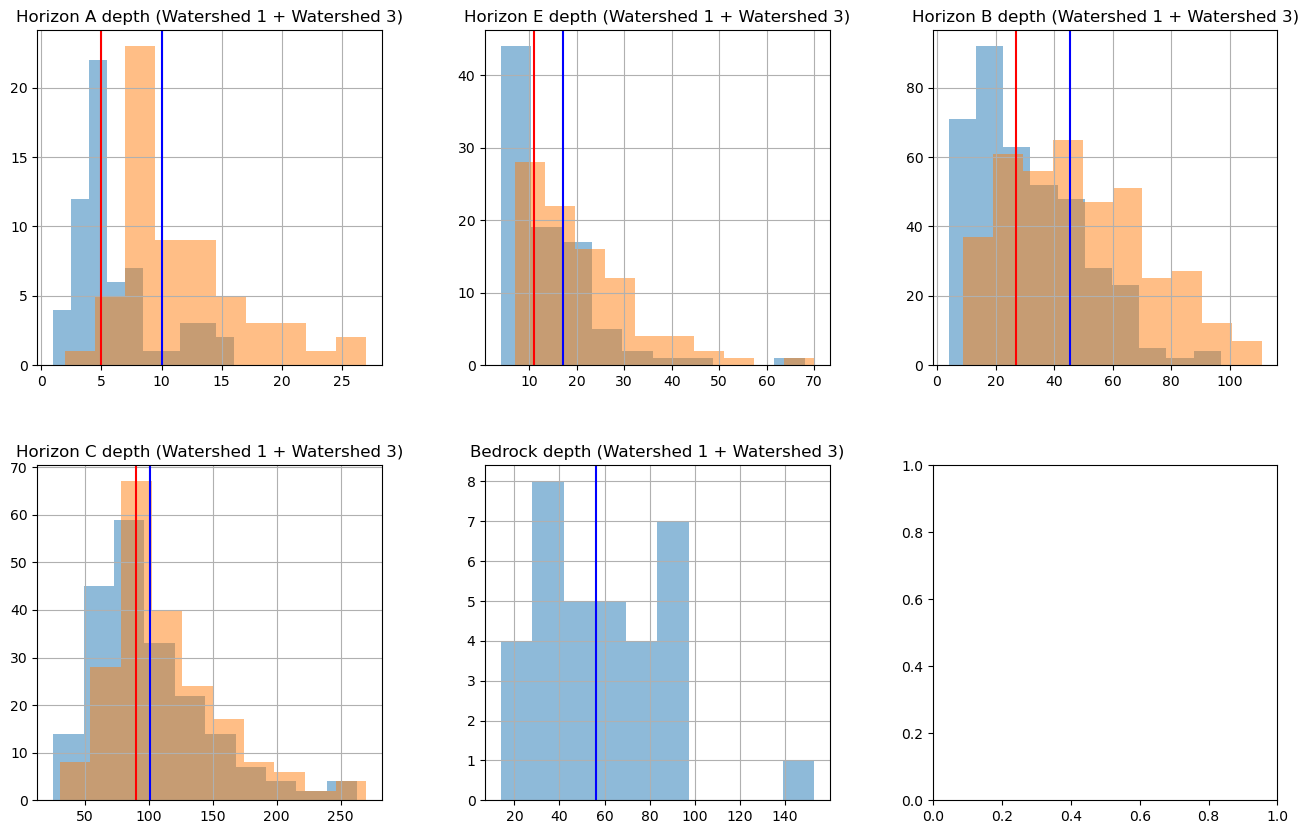

In [6]:
fig, axes = plt.subplots(2, 3, figsize = (16, 10))
for i, h in enumerate(['A','E','B','C']):
    ax = axes.flat[i]
    horizon_top.loc[h].hist(ax = ax, alpha = 0.5)
    ax.axvline(horizon_top.loc[h].median().iloc[0], color = 'r')
    horizon_depth.loc[h].hist(ax = ax, alpha = 0.5)
    ax.axvline(horizon_depth.loc[h].median().iloc[0], color = 'b')
    ax.set_title(f'Horizon {h} depth (Watershed 1 + Watershed 3)')
ax = axes.flat[4]
bedrock_depth.hist(ax = ax, alpha = 0.5)
ax.axvline(bedrock_depth.median(), color = 'b')
ax.set_title('Bedrock depth (Watershed 1 + Watershed 3)')

In [7]:
combined = pd.DataFrame(np.nan, index = ['Oie', 'Oa', 'A', 'E', 'B', 'C'], 
                        columns = ['CEC_ACID', 'CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 'CEC_Al'])
combined.loc[['Oie', 'Oa'], :] = \
    cec_top.loc[['Oie', 'Oa'], 
                ['ExAcidcmolc_kg', 'ExCacmolc_kg', 'ExMgcmolc_kg', 'ExNacmolc_kg', 'ExKcmolc_kg', 'ExAlcmolc_kg']].values
combined.loc[['A', 'E', 'B', 'C'], 'CEC_ACID'] = cec_top.loc['Min', 'ExAcidcmolc_kg']
combined.loc[['A', 'E', 'B', 'C'], ['CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 'CEC_Al']] = \
    cec_min.loc[['A', 'E', 'B', 'C'], 
                ['Ca_NH4Cl', 'Mg_NH4Cl', 'K_NH4Cl', 'Na_NH4Cl', 'Al_NH4Cl']].values
combined.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_CEC.csv'))
combined

,CEC_ACID,CEC_Ca,CEC_Mg,CEC_Na,CEC_K,CEC_Al
Oie,8.918391,9.819770,1.882701,0.113851,1.389885,2.582701
Oa,5.431279,4.407803,0.953468,0.142948,0.740578,7.667283
A,1.677191,3.114444,0.720944,0.538278,0.183556,5.875222
E,1.677191,0.480741,0.128222,0.124407,0.113667,2.530889
B,1.677191,0.307037,0.082505,0.111047,0.119019,5.984318
C,1.677191,0.146900,0.028017,0.053867,0.093000,1.365000


In [8]:
# Convert from soil horizon to ELM soil layers
# Assume Oi = Oe
horizon_interfaces = np.array([0, 2.5, 5, 10, 20, 50, 100])
elm_interfaces = np.array([0, 1.75, 4.51, 9.06, 16.55, 28.91, 49.29, 82.89, 138.28])
horizon_nodes = np.diff(horizon_interfaces)
elm_nodes = np.array([0.71, 2.79, 6.23, 11.89, 21.22, 36.61, 61.98, 100.38])

result = vert_interp(elm_nodes, horizon_nodes, combined.values.T, False,
                     elm_interfaces, horizon_interfaces)
elm_cec = pd.DataFrame(result.T, index = range(1, 9), columns = combined.columns)
elm_cec

,CEC_ACID,CEC_Ca,CEC_Mg,CEC_Na,CEC_K,CEC_Al
1,8.918391,9.819770,1.882701,0.113851,1.389885,2.582701
2,6.378864,5.878447,1.205977,0.135041,0.917020,6.285603
3,2.081477,3.253729,0.745985,0.495704,0.243543,6.068213
4,1.677191,0.811272,0.202609,0.176348,0.122438,2.950605
5,1.677191,0.355523,0.095266,0.114776,0.117525,5.020375
6,1.677191,0.307037,0.082505,0.111047,0.119019,5.984318
7,1.677191,0.150284,0.029168,0.055075,0.093550,1.462611
8,1.677191,0.146900,0.028017,0.053867,0.093000,1.365000


## Soil solution pH and cation concentrations - initial state

In [13]:
data = pd.read_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 
                                'Hubbard_Brook', 'knb-lter-hbr.138.11',
                                'W1Lysim_HB1996-2020.csv'), parse_dates=True)
data = data.loc[pd.DatetimeIndex(data['Date']) < np.datetime64('1999-10-01'), :]
# homogenize the horizon notationss
data['Horizon'] = [r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') else r \
    for r in data['Horizon']]
data.loc[data['Horizon'] == 'Oa', 'Horizon'] = 'Oae'
data.loc[data['Horizon'] == 'Oe', 'Horizon'] = 'Oae'
data = data[['Horizon', 'pH', 'Ca2+', 'Mg2+', 'Na+', 'K+', 'Alt']].set_index('Horizon')
data[data < 0] = np.nan
# umol/L => mol/L
data.iloc[:, 1:] = data.iloc[:, 1:] * 1e-6
data_mean = data.groupby(['Horizon']).mean().loc[['Oae', 'Bhs', 'Bs', 'Bh'], :]
data_05 = data.groupby('Horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 5, axis = 0), index = df.columns)
    ).loc[['Oae', 'Bhs', 'Bs', 'Bh'], :]
data_95 = data.groupby('Horizon').apply(
    lambda df: pd.Series(np.nanpercentile(df, 95, axis = 0), index = df.columns)
    ).loc[['Oae', 'Bhs', 'Bs', 'Bh'], :]

data_mean.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_solution.csv'))
data_mean

,pH,Ca2+,Mg2+,Na+,K+,Alt
Horizon,,,,,,
Oae,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019
Bhs,4.358333,0.000012,0.000007,0.000032,0.000008,0.000025
Bs,4.600450,0.000016,0.000007,0.000031,0.000005,0.000023
Bh,4.643889,0.000021,0.000008,0.000030,0.000012,0.000022


In [ ]:
# Convert from soil horizon to ELM soil layers
# Assume O = A = E
elm_sol = pd.DataFrame(np.nan, index = range(1, 7), columns = data_mean.columns)
elm_sol.loc[1, :] = data_mean.loc['Oae', :].values
elm_sol.loc[2, :] = data_mean.loc['Oae', :].values
elm_sol.loc[3, :] = data_mean.loc['Oae', :].values
elm_sol.loc[4, :] = (data_mean.loc['Oae', :].values * 0.0294 + \
                     data_mean.loc['Bhs', :].values * 0.0455) / 0.0749
elm_sol.loc[5, :] = data_mean.loc['Bhs', :].values
elm_sol.loc[6, :] = data_mean.loc['Bhs', :].values
elm_sol

,pH,Ca2+,Mg2+,Na+,K+,Alt
1,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019
2,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019
3,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019
4,4.347781,0.000017,0.000008,0.000029,0.000014,0.000022
5,4.358333,0.000012,0.000007,0.000032,0.000008,0.000025
6,4.358333,0.000012,0.000007,0.000032,0.000008,0.000025


## Soil texture and organic matter content

ORGANIC:units = "kg/m3 (assumed carbon content 0.58 gC per gOM)"



Deeper data, knb-lter-hbr.210.2

    C_pct
    C percent
    organic carbon concentration, percent by weight
    float

<AxesSubplot:>

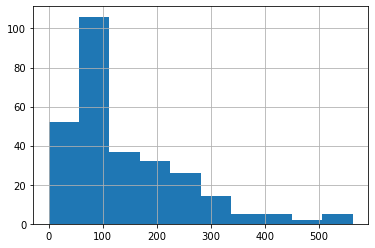

In [ ]:
""" THIS IS NOT USED """
# (1) Check the soil organic matter content in kg/m3
# But not enough layer depth is available
path_chem = os.path.join(os.environ['PROJDIR'], 'DATA', 'Weathering', 
                         'Hubbard Brook', 'knb-lter-hbr.176.3')
layer_depth = pd.read_csv(os.path.join(path_chem, 'HubbardBrook_ForestFloor_SiteInfo_W1.csv'))
layer_chem = pd.read_csv(os.path.join(path_chem, 'HubbardBrook_ForestFloor_SoilChem_W1.csv'))

layer_depth = layer_depth.loc[layer_depth['Year'] <= 1998, :].set_index(['Year', 'Plot'])
layer_depth = layer_depth.loc[:, ['Oie_Thickness1','Oie_Thickness2','Oie_Thickness3',
                                  'Oie_Thickness4','Oie_Thickness5','Oie_Thickness6',
                                  'Oie_Thickness7','Oie_Thickness8']]
layer_depth[layer_depth <= -990] = np.nan
layer_depth = layer_depth.dropna(axis = 0, how = 'all')

layer_chem = layer_chem.loc[layer_chem['Year'] <= 1998, ['Year', 'Plot', 'Horizon', 'OM_OM']]
layer_chem = layer_chem.set_index(['Year','Plot'])

layer_combined = pd.concat([layer_chem, layer_depth], axis = 1
                           ).dropna(axis = 0, subset = list(layer_depth.columns), how = 'all')
layer_combined['Oie_Thickness'] = layer_combined.loc[:, layer_depth.columns].mean(axis = 1)

(layer_combined['OM_OM'] / (layer_combined['Oie_Thickness']*0.01)).hist()

In [ ]:
""" THIS IS USED INSTEAD OF THE ABOVE """
# (2) Use the known organic_max from ELM parameter file to convert % organic matter weight
#     to kg/m3
organic_max = 130
# (2.1) surface
path_chem = os.path.join(os.environ['PROJDIR'], 'DATA', 'Weathering', 
                         'Hubbard Brook', 'knb-lter-hbr.176.3')
layer_chem = pd.read_csv(os.path.join(path_chem, 'HubbardBrook_ForestFloor_SoilChem_W1.csv'))
layer_chem = layer_chem.loc[layer_chem['Year'] <= 1998, ['Year', 'Plot', 'Horizon', 'PercentC']]
layer_chem = layer_chem.set_index(['Year','Plot'])
layer_chem.loc[layer_chem['PercentC'] < -800, 'PercentC'] = np.nan
layer_chem['pct_OM'] = layer_chem['PercentC']/100 * 1.72 * organic_max
layer_chem = layer_chem.groupby('Horizon').mean()
# (2.2) deeper - no data from watershed 1 or 6
filename = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'Hubbard_Brook',
                        'knb-lter-hbr.210.2', 'horizon.csv')
#pedon = pd.read_csv(filename.replace('horizon.csv', 'pedon.csv'))
#pedon = pedon.loc[pedon['project'] == 'WS1lys', 'pedon']
data = pd.read_csv(filename)
data = data[['pedon', 'horizon', 'top_cm', 'base_cm', 'C_pct']]
#data = data.loc[data['pedon'].isin(pedon), :]
data['horizon'] = [
    r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') else r for r in data['horizon']]
data = data.loc[data['horizon'].isin(['A', 'E', 'Bhs']),
                :].drop(['top_cm', 'base_cm'], axis = 1).set_index(['pedon', 'horizon'])
data_mean = data.groupby(['horizon']).mean()
data_mean['pct_OM'] = data_mean['C_pct']/100 * 1.72 * organic_max

combined_chem = pd.Series(np.nan, index = ['Oie', 'Oa', 'A', 'E', 'Bhs'])
combined_chem.loc[['Oie', 'Oa']] = layer_chem.loc[['Oie','Oa'], 'pct_OM'].values
combined_chem.loc[['A', 'E', 'Bhs']] = data_mean.loc[['A', 'E', 'Bhs'], 'pct_OM'].values
combined_chem

Oie    99.389565
Oa     55.047017
A      29.042341
E       4.035448
Bhs    14.013622
dtype: float64

In [ ]:
filename = os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'data', 'Hubbard_Brook',
                        'knb-lter-hbr.210.2', 'horizon.csv')
data = pd.read_csv(filename)
data = data[['pedon', 'horizon', 'top_cm', 'base_cm', 'C_pct']]
data['horizon'] = [
    r[:-1] if r.endswith('1') or r.endswith('2') or r.endswith('3') or r.endswith('4') or r.endswith('5') or r.endswith('6') else r for r in data['horizon']]
data['horizon'] = [
    r[1:] if r.startswith('2') or r.startswith('3') else r for r in data['horizon']]

# print(data['horizon'].drop_duplicates().sort_values())

data = data.loc[data['horizon'].isin(['Bs','Bsm','Bh','Bhm','C','Cd','Cg','Cr','R']), :]
#plt.plot(BS['top_cm'])
#plt.plot(BS['base_cm'])
data_mean = data.groupby(['horizon']).mean()
data_mean['pct_OM'] = data_mean['C_pct']/100 * 1.72 * organic_max
data_mean

<ipython-input-63-715c8ac85c29>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_mean = data.groupby(['horizon']).mean()


,top_cm,base_cm,C_pct,pct_OM
horizon,,,,
Bh,29.706667,49.040000,4.850515,10.845753
Bhm,95.000000,115.000000,0.600000,1.341600
Bs,29.504000,50.072000,3.715385,8.307600
Bsm,48.000000,64.166667,2.500000,5.590000
C,102.911765,119.282353,0.671951,1.502483
Cd,87.964706,101.411765,0.490625,1.097038
Cg,90.105263,108.684211,0.558333,1.248433
Cr,99.000000,108.500000,NaN,NaN
R,53.773585,NaN,NaN,NaN


In [ ]:
# Convert from soil horizon to ELM soil layers
elm_om = pd.Series(np.nan, index = range(1, 7))
elm_om.loc[1] = combined_chem.loc['Oie']
elm_om.loc[2] = (combined_chem.loc['Oie'] * 0.0075 + \
    combined_chem.loc['Oa'] * 0.0201) / 0.0276
elm_om.loc[3] = (combined_chem.loc['Oa'] * 0.0249 + \
    combined_chem.loc['A'] * 0.015 + \
    combined_chem.loc['E'] * 0.0056) / 0.0455
elm_om.loc[4] = (combined_chem.loc['E'] * 0.0294 + \
    combined_chem.loc['Bhs'] * 0.0455) / 0.0749
elm_om.loc[5] = combined_chem.loc['Bhs']
elm_om.loc[6] = combined_chem.loc['Bhs']
elm_om

1    99.389565
2    67.096622
3    40.195700
4    10.096955
5    14.013622
6    14.013622
dtype: float64

In [ ]:
# Put all the ELM inputs together 
elm_input = pd.concat([
    elm_cec, elm_sol, elm_om.to_frame('OM')
], axis = 1)
elm_input['CEC_TOT'] = elm_input[['CEC_ACID', 'CEC_Ca', 'CEC_Mg', 'CEC_Na', 'CEC_K', 
                                  'CEC_Al']].sum(axis = 1).values
elm_input.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_elm_input.csv'))
elm_input

,CEC_ACID,CEC_Ca,CEC_Mg,CEC_Na,CEC_K,CEC_Al,pH,Ca2+,Mg2+,Na+,K+,Alt,OM,CEC_TOT
1,8.918391,9.819770,1.882701,0.113851,1.389885,2.582701,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019,99.389565,24.707299
2,6.378864,5.878447,1.205977,0.135041,0.917020,6.285603,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019,67.096622,20.800952
3,3.731626,3.458012,0.786242,0.294750,0.440583,6.266128,4.331449,0.000025,0.000009,0.000024,0.000023,0.000019,40.195700,14.977340
4,1.677191,0.383052,0.116465,0.156573,0.050064,7.551687,4.347781,0.000017,0.000008,0.000029,0.000014,0.000022,10.096955,9.935033
5,1.677191,0.416333,0.138500,0.186667,0.055333,10.686389,4.358333,0.000012,0.000007,0.000032,0.000008,0.000025,14.013622,13.160413
6,1.677191,0.416333,0.138500,0.186667,0.055333,10.686389,4.358333,0.000012,0.000007,0.000032,0.000008,0.000025,14.013622,13.160413


In [ ]:
co2_atm = 360.7 * 1e-5

elm_input['Ca2+']*2 + elm_input['Mg2+']*2 + elm_input['Na+'] + elm_input['K+'] + elm_input['Alt']*3 + 10**(-elm_input['pH']) # - 10**(-14+elm_input['pH']) - 4.38e-8*co2_atm/10**(-elm_input['pH']) - 2*7.20443620415286e-19*co2_atm/10**(-2*elm_input['pH'])

1    0.000220
2    0.000220
3    0.000220
4    0.000205
5    0.000196
6    0.000196
dtype: float64

In [ ]:
# Calculate the exchange coefficient
K_AH = pd.DataFrame(np.nan, index = elm_input.index,
                    columns = ['Ca', 'Mg', 'Na', 'K', 'Al'])

alpha_theta = 3.4
for ion,ion2,valint in zip(['Ca', 'Mg', 'Na', 'K', 'Al'], 
                           ['Ca2+', 'Mg2+', 'Na+' , 'K+', 'Alt'],
                           [2,2,1,1,3]):
    beta_h = (elm_input['CEC_ACID']/elm_input['CEC_TOT']).values
    h = 10**(-elm_input['pH'].values)
    cation = elm_input[ion2].values
    beta_cation = (elm_input[f'CEC_{ion}'] / elm_input['CEC_TOT']).values

    K_AH.loc[:, ion] = h * beta_cation**(1/valint) / cation**(1/valint) / beta_h

    ## Kanzaki equation
    # K_AH.loc[:, ion] = 10**(alpha_theta*(1-beta_h)) * \
    #    h * beta_cation**(1/valint) / cation**(1/valint) / beta_h
    # print(beta_cation, beta_h)
LOG_K_AH = np.log10(K_AH)
LOG_K_AH.to_csv(os.path.join(os.environ['PROJDIR'], 'ERW_LDRD', 'results', 'HBR_logkm.csv'))
LOG_K_AH.T

,1,2,3,4,5,6
Ca,-1.792095,-1.795342,-1.749039,-1.902450,-1.756803,-1.756803
Mg,-1.926099,-1.914648,-1.846018,-1.992003,-1.884583,-1.884583
Na,-1.607871,-1.388197,-0.816364,-0.837629,-0.815438,-0.815438
K,-0.495827,-0.530884,-0.616390,-1.004327,-0.719555,-0.719555
Al,-2.643365,-2.418892,-2.281595,-2.065427,-1.957438,-1.957438


In [ ]:
beta_h = 0.36096179
h = 10**(-4.331449)
beta_cation = 0.3974441
cation = 0.000025
valint = 2
10**(3.4*(1-beta_h)) * h * beta_cation**(1/valint) / cation**(1/valint) / beta_h

2.4237493476736502

## Check surface CEC and solution over time

In [ ]:
data = pd.read_excel(os.path.join(os.environ['PROJDIR'], 'DATA', 'Weathering', 
                                  'Hubbard Brook', 'knb-lter-hbr.158.1',
                                  'w1ffexchem.xlsx'),
                     index_col = [3, 1, 2])

# 'Min', 'cor', 'min' probably all means mineral soil of top 10cm
new_index_level_0 = [t if t in ['Oa', 'Oie'] else 'Min' for t in data.index.get_level_values(0)]
data.index = pd.MultiIndex.from_arrays([new_index_level_0, data.index.get_level_values(1),
                                        data.index.get_level_values(2)], 
                                        names = ['Horizon','Year','Plot'])

data = data[['ExAcidcmolc_kg','ExCacmolc_kg', 'ExMgcmolc_kg', 
             'ExNacmolc_kg', 'ExKcmolc_kg', 'ExAlcmolc_kg']].sort_index()
data[data < 0] = np.nan

data

ExAcidcmolc_kg  ExCacmolc_kg  ExMgcmolc_kg  ExNacmolc_kg  \
Horizon Year Plot                                                              
Min     1998 3.0              7.45          0.11          0.13          0.10   
             4.0             15.48          0.46          0.34          0.23   
             7.0             14.08          0.24          0.46          0.16   
             10.0             6.38          0.18          0.17          0.07   
             12.0            12.94          0.88          0.42          0.18   
...                            ...           ...           ...           ...   
Oie     2010 192.0            5.42         39.84          3.93          0.03   
             194.0            8.49         27.30          4.66          0.11   
             196.0            4.55         19.52          3.09          0.03   
             197.0            3.84          4.12          1.01          0.25   
             199.0            5.49          6.02          1.42          0.06   

                    ExKcmolc_kg  ExAlcmolc_kg  
Horizon Year Plot                              
Min     1998 3.0           0.17          3.53  
             4.0           0.49         16.05  
             7.0           0.53          8.74  
             10.0          0.24          4.54  
             12.0          0.45          9.59  
...                         ...           ...  
Oie     2010 192.0         1.70           NaN  
             194.0         2.61           NaN  
             196.0         1.54           NaN  
             197.0         0.56           NaN  
             199.0         0.94           NaN  

[1661 rows x 6 columns]

<Figure size 576x432 with 0 Axes>

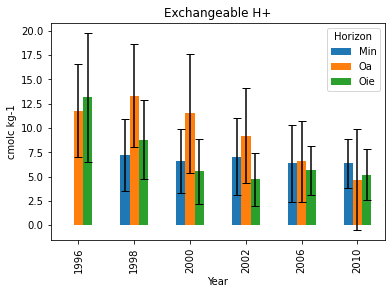

<Figure size 576x432 with 0 Axes>

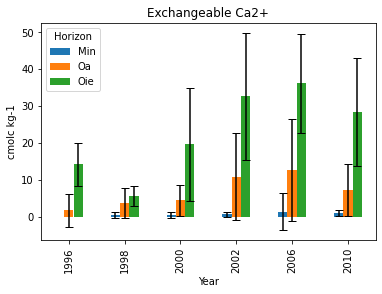

<Figure size 576x432 with 0 Axes>

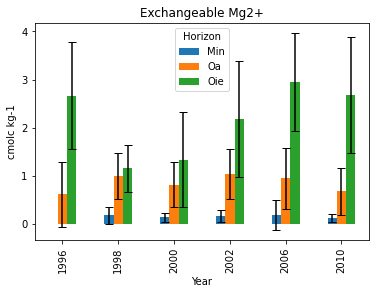

<Figure size 576x432 with 0 Axes>

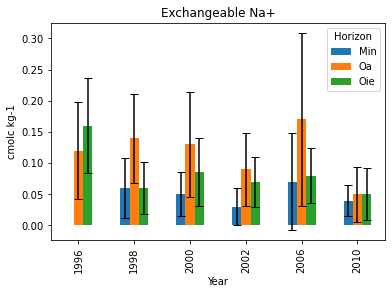

<Figure size 576x432 with 0 Axes>

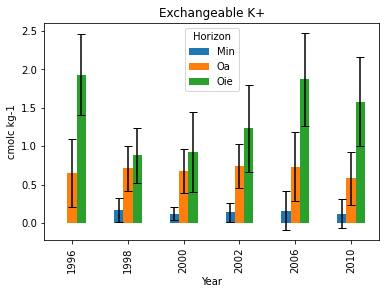

<Figure size 576x432 with 0 Axes>

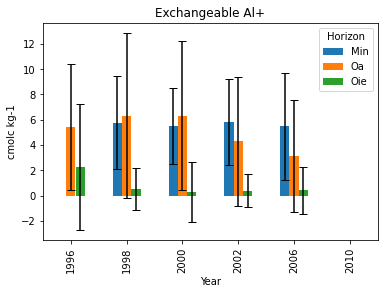

In [ ]:
for cation in data.columns:
    data_mean = data[cation].groupby(['Year', 'Horizon']).median().unstack()
    data_std = data[cation].groupby(['Year', 'Horizon']).std().unstack()

    plt.figure(figsize = (8,6))
    data_mean.plot(kind='bar', yerr=data_std, capsize=4)

    cation = cation.replace('cmolc_kg','').replace('Ex','')
    if cation == 'Acid':
        cation = 'H+'
    elif cation in ['Ca','Mg']:
        cation = cation + '2+'
    else:
        cation = cation + '+'
    plt.title(f'Exchangeable {cation}')
    plt.ylabel('cmolc kg-1')
    plt.savefig(f'./temp/hbr_soil_{cation}.png', dpi = 600, bbox_inches = 'tight')

<AxesSubplot:xlabel='Date'>

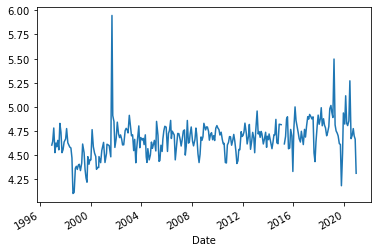

In [ ]:
data = read_lysimeter()
data['pH'].plot()